In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [28]:
class NeuralNet:
    
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):
        
        self.params = {}
        self.params['W1'] = np.random.randn(input_size, hidden_size)*std
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = np.random.randn(hidden_size, output_size)*std
        self.params['b2'] = np.zeros(output_size)
        
    def loss(self, X, y, reg=0.01):
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        N, D = X.shape
        
        
        hidden_scores = np.maximum(0, np.dot(X, W1) + b1)
        scores = np.dot(hidden_scores, W2) + b2
        
        
        loss = np.sum(-scores[range(N), y] + np.log(np.sum(np.exp(scores), axis=1)))
        loss /= N
        loss += 0.5*reg*np.sum(W1*W1) + 0.5*reg*np.sum(W2*W2)
        
        
        grads = {}
        dprobs = np.exp(scores)/np.sum(np.exp(scores), axis=1, keepdims=True)
        dprobs[range(N),y] -= 1
        dprobs /= N
        

        grads['W2'] = np.dot(hidden_scores.T, dprobs)
        grads['b2'] = np.sum(dprobs, axis=0)
        
        dhidden_scores = np.dot(dprobs, W2.T)
        dhidden_scores[hidden_scores <= 0] = 0
        
        grads['W1'] = np.dot(X.T, dhidden_scores)
        grads['b1'] = np.sum(dhidden_scores, axis=0)
        
        
        grads['W1'] += reg*W1
        grads['W2'] += reg*W2
        
        return loss, grads
        
        
    def train(self, X, y, X_val, y_val, learning_rate=1e-3,
              learning_rate_decay=0.95, reg=0.01, epochs=100,
              batch_size=128, verbose=True):
        
        N = X.shape[0]
        iters_per_epoch = int(N/batch_size)
        
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        
        
        for i in range(epochs):
            idx = np.random.choice(N, batch_size, replace=True)
            X_batch = X[idx]
            y_batch = y[idx]
            
            loss, grads = self.loss(X_batch, y_batch, reg=reg)
            loss_history.append(loss)
            
            for param in self.params:
                self.params[param] -= learning_rate*grads[param]
                
            if verbose and i%100==0:
                print('Iteration {}/{} loss {}'.format(i, epochs, loss))
                
                
            if i%iters_per_epoch==0:
                learning_rate *= learning_rate_decay
                train_acc = np.mean(self.predict(X_batch)==y_batch)
                val_acc = np.mean(self.predict(X_val)==y_val)
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                
                
        return {'loss_history':loss_history,
                'train_acc_history':train_acc_history,
                'val_acc_history':val_acc_history
               }

            
            
    def predict(self, X):
        
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        hidden_scores = np.maximum(0, np.dot(X, W1)+b1)
        scores = np.dot(hidden_scores, W2) + b2
        y_pred = np.argmax(scores, axis=1)
        

        return y_pred



In [18]:
def load_data(num_training=49000, num_validation=1000, num_test=1000):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
    X_train = X_train.astype('float')
    X_test = X_test.astype('float')
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)
    y_train = y_train.reshape(y_train.shape[0])
    y_test = y_test.reshape(y_test.shape[0])
    y_val = y_val.reshape(y_val.shape[0])
    return X_train, y_train, X_val, y_val, X_test, y_test

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = load_data()

In [29]:
input_size = X_train[0].size
hidden_size = 70
num_classes = np.unique(y_train).size
nnet = NeuralNet(input_size, hidden_size, num_classes)

stats = nnet.train(X_train, y_train, X_val, y_val, 
                  epochs=1000, batch_size=256,
                  learning_rate=1e-3, verbose=True)
val_acc = np.mean(nnet.predict(X_val)==y_val)
print('Val_acc:', val_acc)

Iteration 0/1000 loss 2.3025735695823273
Iteration 100/1000 loss 1.880426447891901
Iteration 200/1000 loss 1.7571692047009884
Iteration 300/1000 loss 1.5732094381777444
Iteration 400/1000 loss 1.6970438771954541
Iteration 500/1000 loss 1.5219457627568698
Iteration 600/1000 loss 1.4385580946697218
Iteration 700/1000 loss 1.5612104042961639
Iteration 800/1000 loss 1.5378591649912814
Iteration 900/1000 loss 1.5126038600412812
Val_acc: 0.48


In [32]:
stats.keys()

dict_keys(['val_acc_history', 'train_acc_history', 'loss_history'])

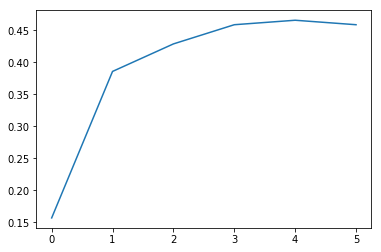

In [33]:
plt.plot(stats['val_acc_history'])

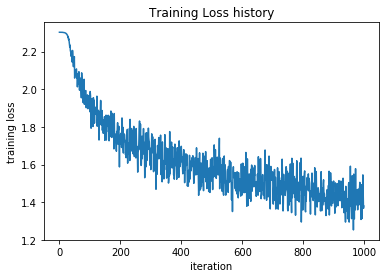

In [31]:
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

In [36]:
best_net = None 
results = {}
best_val = -1
hidden = [100, 200]
learning_rates = [1e-5, 3e-7]
regularization_strengths = [1e-1, 1e2, 1e3]

for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_size in hidden:
            net = NeuralNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val, learning_rate=lr, reg=reg, 
                          epochs=1500,verbose=True)
            y_train_pred = net.predict(X_train)
            y_val_pred = net.predict(X_val)
            acc_train = np.mean(y_train_pred == y_train)
            acc_val = np.mean(y_val_pred == y_val)
            results[(lr, reg, hidden_size)] = (acc_train, acc_val)

            if acc_val > best_val:
                best_val = acc_val
                best_net = net
    
for lr, reg, hid in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, hid)]
    print('lr %e reg %e hidden_size %d train accuracy: %f val accuracy: %f' % (
                lr, reg,hid, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)




Iteration 0/1500 loss 2.302732043242531
Iteration 100/1500 loss 2.3027030422210353
Iteration 200/1500 loss 2.3026350828296875
Iteration 300/1500 loss 2.302600823101799
Iteration 400/1500 loss 2.30259201599773
Iteration 500/1500 loss 2.302462590063405
Iteration 600/1500 loss 2.302364300607491
Iteration 700/1500 loss 2.3022551352266944
Iteration 800/1500 loss 2.302181505973314
Iteration 900/1500 loss 2.302176690679615
Iteration 1000/1500 loss 2.302131930695874
Iteration 1100/1500 loss 2.301635737557951
Iteration 1200/1500 loss 2.3007895772819897
Iteration 1300/1500 loss 2.301417965608663
Iteration 1400/1500 loss 2.300425116655862
Iteration 0/1500 loss 2.3029040703615618
Iteration 100/1500 loss 2.302789112477718
Iteration 200/1500 loss 2.302686782613512
Iteration 300/1500 loss 2.3025676901178556
Iteration 400/1500 loss 2.30261558309209
Iteration 500/1500 loss 2.3023371371751975
Iteration 600/1500 loss 2.3023421637668564
Iteration 700/1500 loss 2.3020997721062373
Iteration 800/1500 loss 2.